## TODO

In [2]:
# PLAN MONDAY 
# FIX Model input Data 
# TODO Create equivalent variables but flip nodes with edges 

# DONE Understand architecture 
# DONE Understand model input data 
# DONE There are missing connections in the adjacency matrix # IDEA scrap adjacency matrix entirely if necessary? 
# DONE Create model without NeighborSampler 
# DONE Clean code 
# DONE Make model work ... 

# PLAN TUESDAY 
# TODO ADMIN - Send email with Update (ask about servers?) 
# TODO CODE - Make model more extensive 
# TODO CODE - Visualize prediction patterns and learning curve for existing model 
# TODO CODE - Create testing stage and evaluation 
# TODO THEORY - Watch GNN Theory 
# TODO THEORY - Write up Introduction 

# PLAN WEDNESDAY 
# TODO THEORY - Understand Math Theory 
# TODO THEORY - Write up methodology theory 
# TODO THEORY - Write up Literature Review 

# PLAN THURSDAY 
# TODO CODE - add statistics to a new DataFrame 
# TODO CODE - add average of transactions for accounts 

In [1]:
import pickle
import torch
import time
import random
import datetime
import numpy as np
import pandas as pd
import networkx as nx
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from functions import *
from pandas import Timestamp
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from torch_geometric.utils import negative_sampling, train_test_split_edges


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# LOADING GRAPH from Jupyter Notebook 
\(only use if not using Class Preprocessor)

In [ ]:
# with open("graph_data.pickle", "rb") as f:
#     loaded_data = pickle.load(f)
# # fraudulent transaction:
# fraudulent_transaction = (labels==1).nonzero().squeeze()
# print(fraudulent_transaction)
# print(input_data)

# PROCESS DATA directly

Data Head - <bound method NDFrame.head of              Timestamp  From Bank    Account  To Bank  Account.1  \
0     2022/09/01 00:20         10  8000EBD30       10  8000EBD30   
1     2022/09/01 00:20       3208  8000F4580        1  8000F5340   
2     2022/09/01 00:00       3209  8000F4670     3209  8000F4670   
3     2022/09/01 00:02         12  8000F5030       12  8000F5030   
4     2022/09/01 00:06         10  8000F5200       10  8000F5200   
...                ...        ...        ...      ...        ...   
4994  2022/09/01 00:15      11318  80087D580    11318  80087D580   
4995  2022/09/01 00:02       1674  80087D1B0     1674  80087D1B0   
4996  2022/09/01 00:19        220  80087EA60      220  80087EA60   
4997  2022/09/01 00:19       2843  8008789D0     2843  8008789D0   
4998  2022/09/01 00:29       1674  80087AC10     1674  80087AC10   

      Amount Received Receiving Currency  Amount Paid Payment Currency  \
0             3697.34          US Dollar      3697.34        US Dol

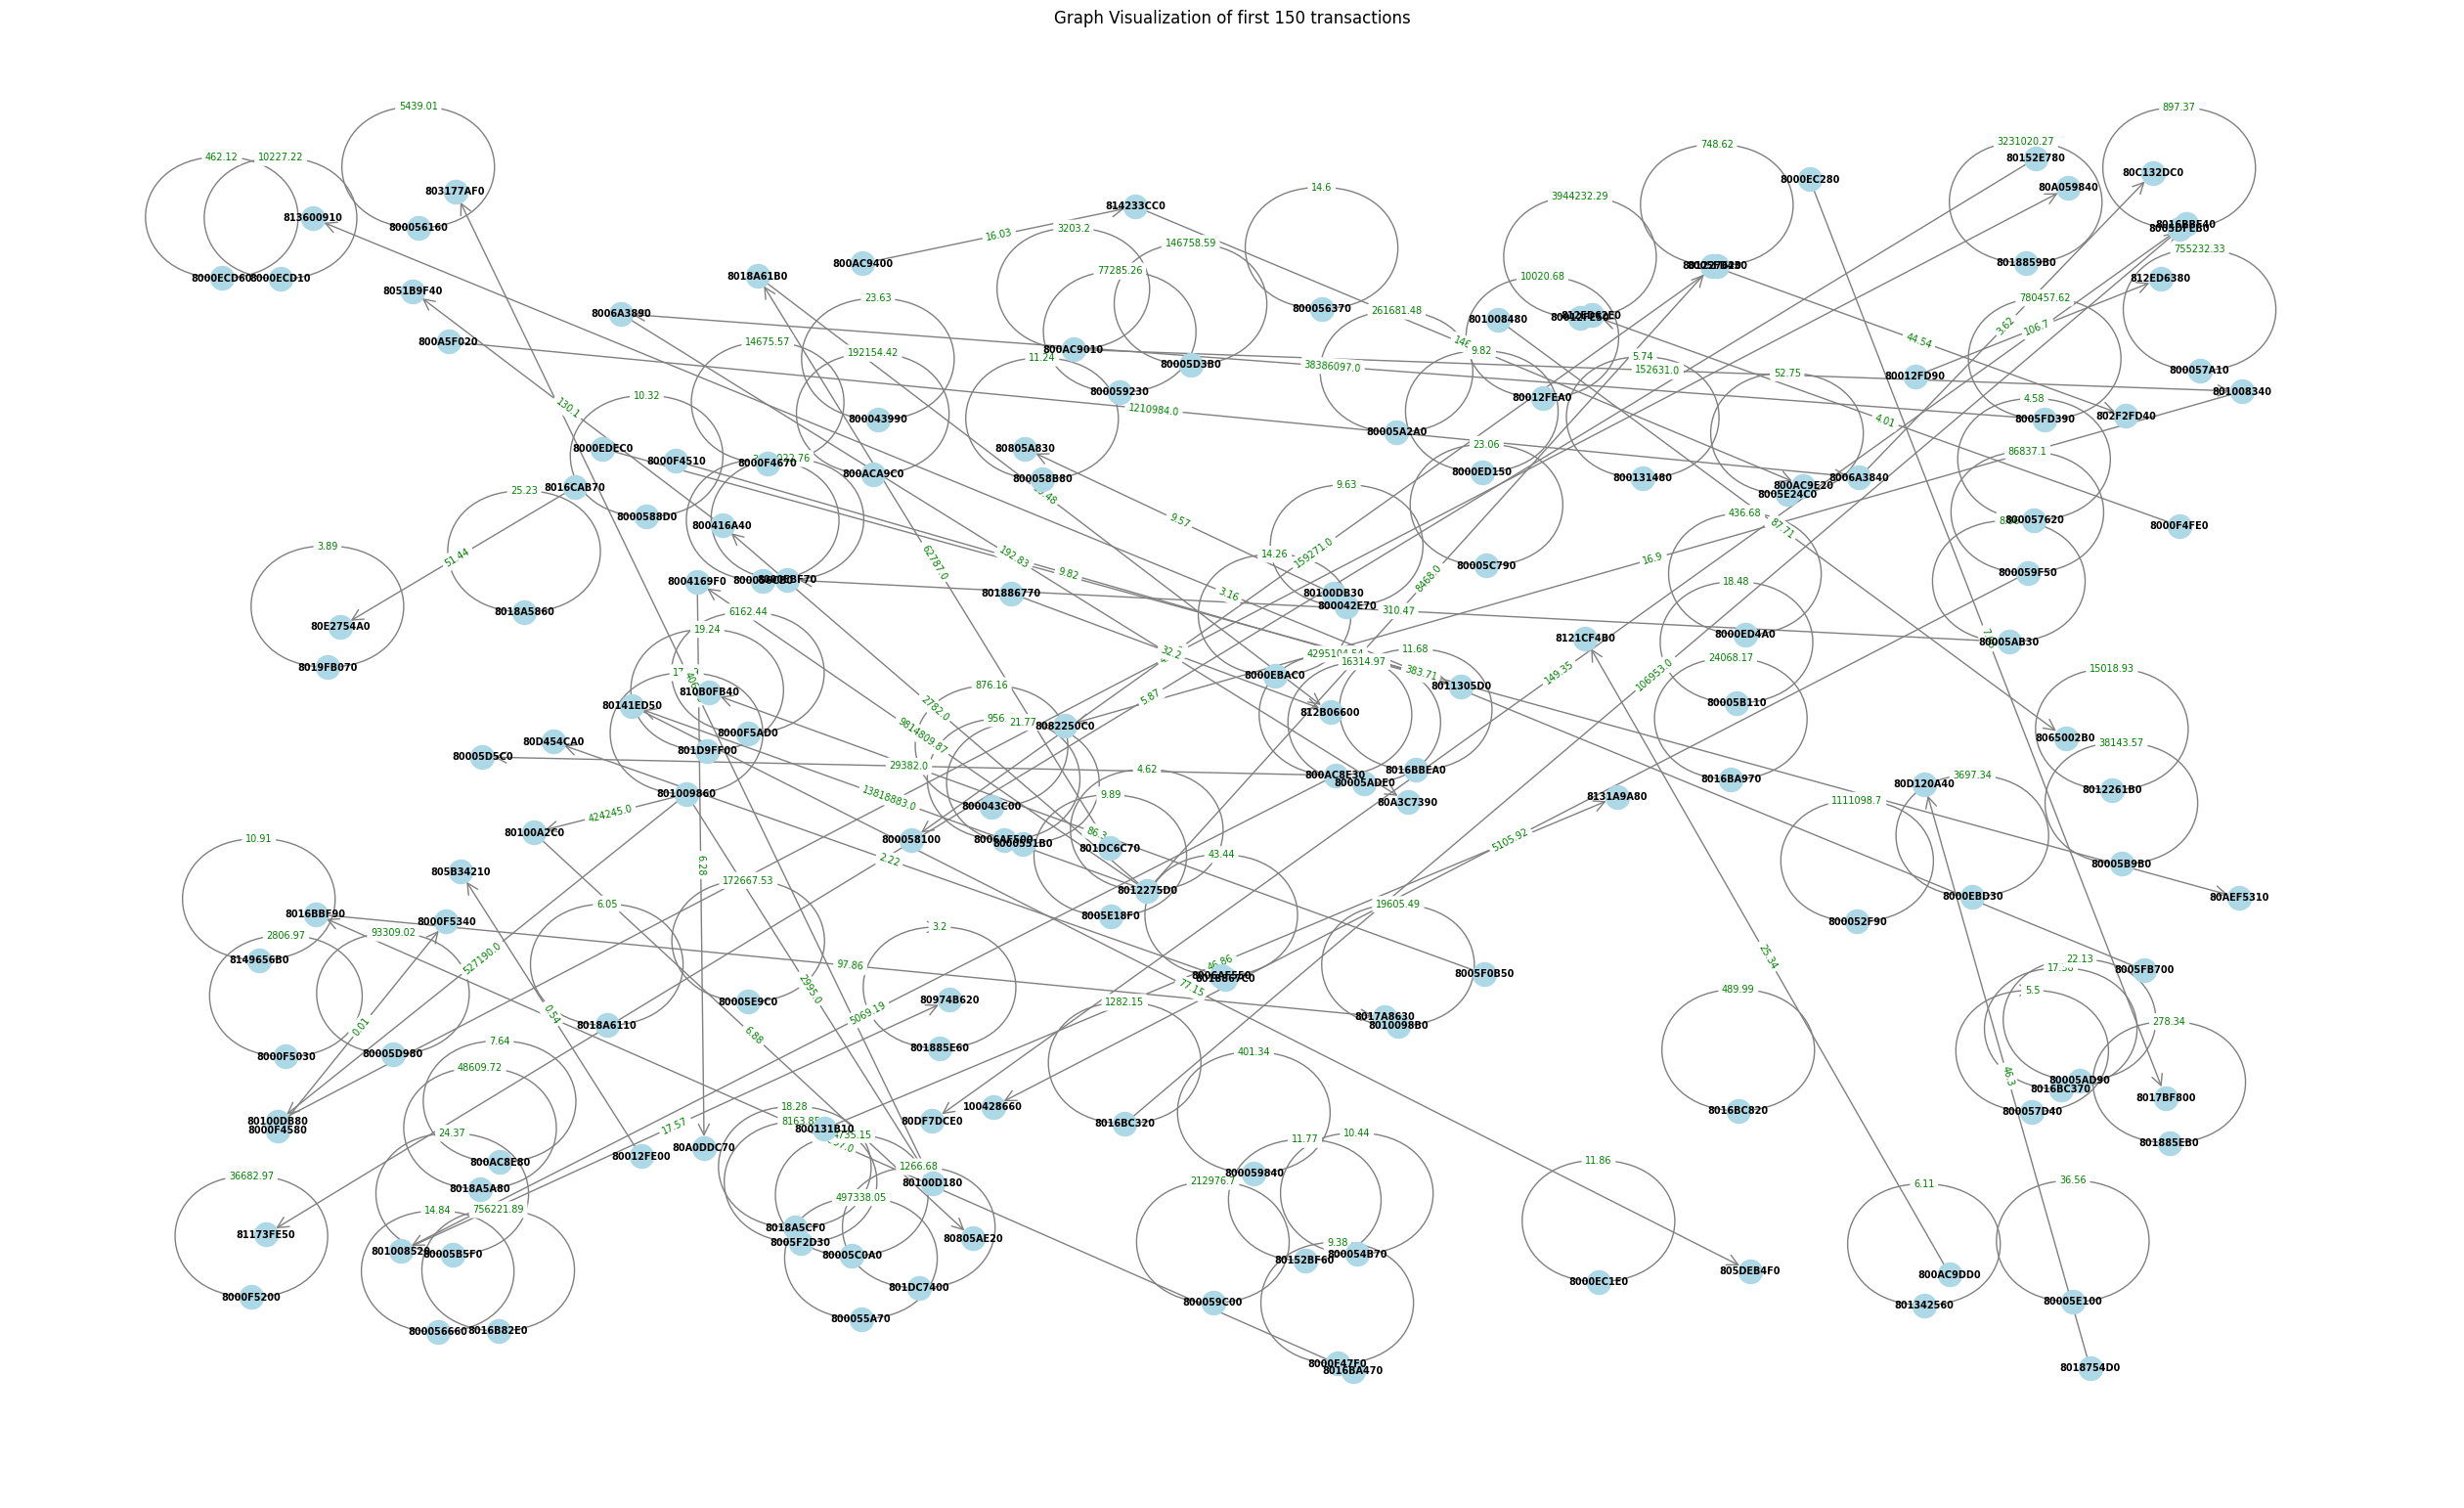

In [2]:
filename = '/Users/owhy/Documents/Datasets/HI-Small_Trans_3.csv'
# Create an instance of the AMLDataPreprocessing class
data_preprocessor = AMLDataPreprocessing(filename)
# Process the data
input_data, graph_full, x, y, labels, links, edges_amount, node_features, edges_features = data_preprocessor.process_data()
# Visualize
visual = data_preprocessor.visualize_graph(links, edges_amount)

# GRAPH NEURAL NETWORKS

In [3]:
class GCN01(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN01, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.relu1 = nn.ReLU()
        self.conv2 = GCNConv(hidden_channels, 128)
        self.relu2 = nn.ReLU()
        self.conv3 = GCNConv(128, 256)
        self.relu3 = nn.ReLU()
        self.conv4 = GCNConv(256, 128)
        self.relu4 = nn.ReLU()
        self.conv5 = GCNConv(128, hidden_channels)
        self.relu5 = nn.ReLU()
        self.conv6 = GCNConv(hidden_channels, out_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [4]:
print(input_data.x.size())
print(input_data.y.size())

torch.Size([4188, 31])
torch.Size([4999])


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define hyperparameters
num_epochs = 300
hidden_channels = 128
out_channels = 64
learning_rate = 0.01

# Initialize the model, optimizer, and loss function
# model = LinkPredictor(in_channels=input_data.num_features, hidden_channels=64, out_channels=32, heads=8).to(device)
# optimizer = optim.SGD(params=model.parameters(), lr=learning_rate) # IDEA SGD = Stochastic Gradient Descent
# # criterion = torch.nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss() # IDEA used for binary classification tasks --> SIGMOID + BINARY CROSS-ENTROPY LOSS

# Initialize the model, optimizer, and loss function
model = GCN01(in_channels=node_features.size(1), hidden_channels=hidden_channels, out_channels=out_channels).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

# Define the data loader
loader = DataLoader([input_data], batch_size=1, shuffle=True)

loss_values = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_fraudulent_edges = 0  # Initialize total count of fraudulent edges
    fraudulent_indices = []
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        
        # Reshape the output tensor to match the shape of the target tensor
        out = out.view(-1)  # Flatten the output tensor
        
        # Ensure the dimensions of out and batch.y match
        if out.size(0) != batch.y.size(0):
            batch_size = batch.y.size(0)
            out = out[:batch_size]  # Trim the output tensor to match the batch size
        
        # Compute the binary cross-entropy loss
        loss = criterion(out, batch.y.float())  # Ensure batch.y is float type
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        # Predictions: convert logits to probabilities using sigmoid
        probabilities = torch.sigmoid(out)
        
        # Threshold probabilities to predict fraud (1) or non-fraud (0)
        predicted_labels = (probabilities > 0.5).int()  # Threshold at 0.5
        
        # Count the number of fraudulent edges (predicted as 1)
        fraudulent_edges_in_batch = (predicted_labels == 1).sum().item()
        total_fraudulent_edges += fraudulent_edges_in_batch

        # Find indices of fraudulent transactions
        batch_indices = torch.arange(len(predicted_labels))
        fraudulent_indices_batch = batch_indices[predicted_labels == 1].tolist()
        fraudulent_indices.extend(fraudulent_indices_batch)
    
    loss_values.append(total_loss)  # Store the total loss for this epoch
    print(f'Epoch {epoch + 1}, Loss: {total_loss}, Fraudulent Edges: {total_fraudulent_edges}')
    print("Fraudulent Transaction Indices:", fraudulent_indices)


Epoch 1, Loss: 0.7057877779006958, Fraudulent Edges: 2564
Fraudulent Transaction Indices: [0, 3, 4, 5, 7, 8, 9, 11, 15, 16, 17, 22, 24, 26, 28, 30, 31, 32, 33, 37, 38, 40, 44, 45, 47, 48, 50, 55, 56, 58, 59, 60, 61, 63, 64, 65, 67, 68, 69, 71, 72, 73, 79, 81, 82, 83, 84, 85, 86, 89, 92, 93, 94, 95, 96, 98, 99, 104, 106, 108, 115, 117, 119, 120, 123, 124, 125, 132, 133, 135, 137, 138, 139, 144, 147, 148, 150, 151, 153, 154, 156, 158, 159, 160, 161, 167, 168, 169, 171, 172, 174, 175, 176, 180, 183, 184, 186, 187, 188, 189, 191, 192, 197, 199, 200, 201, 204, 206, 208, 209, 210, 211, 212, 213, 214, 215, 217, 219, 221, 223, 224, 227, 234, 236, 237, 238, 240, 241, 243, 247, 249, 250, 251, 252, 253, 254, 260, 261, 263, 266, 267, 271, 272, 275, 276, 278, 279, 280, 281, 282, 284, 286, 287, 288, 293, 295, 297, 299, 300, 302, 303, 304, 308, 311, 312, 313, 314, 315, 317, 319, 320, 321, 324, 325, 328, 329, 334, 335, 336, 337, 338, 339, 340, 341, 343, 345, 346, 347, 349, 351, 352, 354, 355, 360, 362

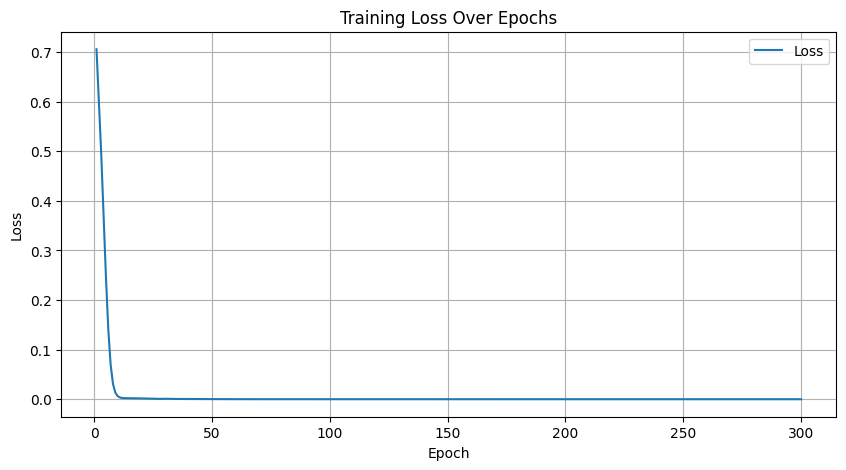

In [12]:
# Plot the loss values
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_values, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# TESTING

In [ ]:
filename = '/Users/owhy/Documents/Datasets/HI-Small_Trans_3_testing.csv'
# Create an instance of the AMLDataPreprocessing class
data_preprocessor = AMLDataPreprocessing(filename)
# Process the data
new_input_data, graph_full, x, y, labels, links, edges_amount = data_preprocessor.process_data()
# Visualize
visual = data_preprocessor.visualize_graph(links, edges_amount)

In [ ]:
# Assuming model is already trained and you have new data for prediction
# For demonstration purposes, let's assume you have a new graph represented as `new_input_data`

# Set model to evaluation mode
model.eval()

# Make predictions on the new data
with torch.no_grad():
    new_input_data = new_input_data.to(device)
    predicted_logits = model(new_input_data.x, new_input_data.edge_index)
    predicted_probabilities = torch.sigmoid(predicted_logits)

# Convert logits to probabilities using sigmoid
predicted_labels = (predicted_probabilities > 0.5).int()  # Threshold at 0.5

# Visualize the predictions
# For example, you could print out the predicted labels for each edge
for i, edge in enumerate(new_input_data.edge_index.t().tolist()):
    print(f'Edge {edge}: Predicted Probability: {predicted_probabilities[i].item()}, Predicted Label: {predicted_labels[i].item()}')
